# Análisis Exploratorio y Curación de Datos

**Todo ejercicio debe tener un análisis fundamentado en la teoría vista en la materia, dicho análisis sera parte del informe a entregar en pdf**

El *dataset* contiene las siguientes columnas:

- **rac y dec** = Posición angular, rac de 0 a 360 y dec de -90 a 90
- **Mag_u,Mag_g,Mag_r,Mag_i,Mag_z**= Estas variables representan una fracción de la luz total que observamos de las galaxias según su frecuencia (como por ejemplo, la frecuencia de radio, para más información [wiki](https://es.wikipedia.org/wiki/Espectro_visible))
- **z** = Es una medida de la distancia a la que se encuentra la galaxia
- **R** = Es una medida del tamaño de la galaxia
- **color**= Como su nombre lo indica es el color más predominante en la galaxia
- **elíptica, espiral, irregular**= Estas columnas identifican el tipo de morfología de las galaxias. Si el valor de una de estas tres columnas es 1, entonces la galaxia tiene esa morfología y las dos restantes tendran el valor 0. 

# Paquetes necesarios 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units
from astroquery.skyview import SkyView
import numpy as np
import missingno as msno
from astropy import units as u
import seaborn
seaborn.set_context('talk')

In [2]:
def remove_outlier(df_in, col_name, iqr_factor):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

# AEyC

### Cargar el conjunto de datos 'galaxias1.csv' como un DataFrame, el mismo tiene las propiedades físicas de las galaxias.

- Definir el id como index del DataFrame
- Mostrar el tipo de dato de cada columna 
- Observar si hay filas e indices duplicados, en caso de encontrar valores duplicados decida si los mismos deben ser eliminados, justifique por qué.
- Realicen algunas exploraciones más sobre el dataset
- Remplaze los valores faltantes/NaN/carentes de sentido físico con **KNNImputer**
- Elimine los *outliers* de cada Feature (ver defición de valores atípicos o *outliers* en boxplot.pdf), indique el porcentaje de valores que se están eliminando
- Genere un nuevo DataFramen (df1). 

### Carga y lectura de archivo galaxias_1.csv

In [3]:
data_original = pd.read_csv('galaxias_1.csv', sep=',')

In [4]:
data_original.sample(10,random_state=123)

,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain
19572,"1,23765760749765E+018",123.805910,36.776563,19.08556,17.54430,16.84741,16.37789,15.99599,14.431050,0.042094,-2.238153,0,1,0
47594,"1,23766230727184E+018",236.671434,30.351393,17.46831,15.71435,14.97788,14.63240,14.36831,8.411476,0.031949,-2.490435,0,0,1
55860,"1,23766410470287E+018",145.460739,10.748317,18.29736,16.44632,15.57925,15169.00000,14.84991,6.944691,0.048422,-2.718111,1,0,0
59474,"1,23767193604129E+018",254.650370,40.699307,19.25356,17.93743,17.56856,17.32045,17.48283,10.043970,0.029990,-1.685001,0,0,1
85848,"1,23765549597865E+018",201.394331,-1.553074,18.78843,17.29002,16.83778,16.53923,16.35315,10.911070,0.044366,-1.950645,0,0,1
74158,"1,23765933031568E+018",247.710673,38.763312,17.68026,16.85565,16.58565,16.41258,16.29905,8.365392,0.032376,-1.094606,0,0,1
76077,"1,23766185147479E+018",202.183564,43.930695,16.49429,16.11075,16.33185,16.39906,16.42290,4.055253,0.027969,-0.162436,0,0,1
23690,"1,23766230727544E+018",244.334041,25.657786,19.55392,18.20434,17.66943,17.42545,17.24907,10.020170,0.048300,-1.884485,0,0,1
48367,"1,23766230244629E+018",244.040661,34.165787,18.49640,17.20975,16.81768,16.56079,16.46296,8.123385,0.037806,-1.678722,0,0,1
86474,"1,23764872121811E+018",151.220749,-0.058335,17.58110,16.14195,15.44801,15.06701,14.78960,18.357700,0.021477,-2.133091,0,1,0


In [10]:
data_original[data_original.duplicated()].sort_values(['dec'])

,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain
27154,"1,2376602397775E+018",51.560433,-0.687173,18.40323,17.33583,16.96393,16.76737,16.63186,10.294210,0.021650,-1.439301,0,1,0
70897,"1,2376570700894E+018",36.596322,-0.491854,18.82296,17.77973,17.47922,17.17294,17.02636,8.950567,0.021148,-1.343746,0,0,1
42390,"1,23765173738229E+018",213.595792,2.978021,17.07984,15.18035,14.26774,13.82781,13.50114,23.141960,0.026165,-2.812099,0,0,1
46077,"1,23766224659579E+018",209.583963,7.225087,16.07774,14.77386,14.13092,13.78163,13.47233,24.426840,0.024556,-1.946819,0,1,0
73582,"1,23766195135015E+018",235.731238,9.228520,18.11033,16.22853,15.27528,14.73241,14.31919,20.973250,0.034623,-2.835043,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77030,"1,23766135700796E+018",186.371858,47.273205,16.05042,14.34547,13.53434,13.15750,12.84926,23.705170,0.024868,-2.516076,0,1,0
87068,"1,23766143484671E+018",189.890009,47.623285,15.83679,14.45774,13.80969,13.44220,13.18542,23.371910,0.024251,-2.027100,0,1,0
11357,"1,23766143538437E+018",192.665965,47.933419,18.05920,15.64427,14.63559,14.08723,13.76011,13.652620,0.029494,-3.423610,0,1,0
90046,"1,23765534781217E+018",220.906458,56.772679,18.49025,16.62319,15.77129,15.35340,15.02012,7.065283,0.042816,-2.718963,0,0,1


In [12]:
data_original[data_original.duplicated(subset=['objID'])].sort_values(['objID'])

,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain
66786,"1,23764594397649E+018",50.827067,0.939875,18.73190,17.42271,16.80514,16.47006,16.18039,4.835532,0.036489,-1.926760,0,0,1
66787,"1,23764594397649E+018",50.827067,0.939875,18.73190,17.42271,16.80514,16.47006,16.18039,4.835532,0.036678,-1.926760,0,0,1
26722,"1,23764594397741E+018",52.935881,1.047554,18.82419,17.60955,17.07287,16.79243,16.64695,8.152502,0.031016,-1.751318,0,0,1
25502,"1,23764594397833E+018",55.053168,0.885874,18.97668,17.53440,17.04177,16.80851,16.66080,13.054510,0.038794,-1.934912,0,1,0
90834,"1,23764594397839E+018",55.123625,0.872487,18.28252,16.52093,15.60923,15.08733,14.62764,18.851100,0.040696,-2.673291,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52705,"1,23768024090634E+018",343.304171,-8.196775,17.33667,16.14818,15.62663,15.34346,15.02331,9.619887,0.027473,-1.710036,0,1,0
60607,"1,23768024091132E+018",354.835710,-8.619133,17.36271,16.13077,15.52814,15.21014,14.93630,11.476360,0.034090,-1.834565,1,0,0
30215,"1,23768024092351E+018",22.998652,-8.275140,19.65293,17.09929,16.17692,15.70902,15.34659,9.233762,0.040648,-3.476006,0,1,0
14518,"1,23768024143423E+018",322.765171,-6.232822,19.10234,17.69802,17.36507,17.23353,17.14699,6.579560,0.024794,-1.737274,0,0,1


In [13]:
print('El DataFrame original cuenta con',format(data_original.count()[0]),'filas')

El DataFrame original cuenta con 92102 filas


### Definir el id como index del DataFrame

In [14]:
data_original[data_original.duplicated(subset=['objID'], keep='first')].shape[0]

34421

Hay 34421 objID repetidos, son muchos, esto puede ser debido a que son muestras del mismo objeto. En este caso se propone unificarlos.

In [15]:
data = data_original.copy()

In [16]:
def convert_index(value):
    if (type(value) == type('string') and len(value) > 5):
        new_value = value.replace('E+018','')
        return new_value

Transformo los valores de id quitandole 

In [17]:
for index, row in data.iterrows():
    data['id'] = convert_index(row.objID)
print("finish")

finish


In [18]:
data

,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain,id
0,"1,23765119242489E+018",116.519097,39.886407,17.76235,16.72601,16.33972,16.06614,15.90478,8.393773,0.041521,-1.422625,0,1,0,"1,23765546806247"
1,"1,23765149575578E+018",116.451900,41.421270,18.12179,16.26214,15.39272,14.97515,14.65105,9.674847,0.040211,-2.729061,0,0,1,"1,23765546806247"
2,"1,23767370611537E+018",115.946713,41.918877,18.57293,17.42053,17.01788,16.75617,16.70899,11.277470,0.024386,-1.555044,0,0,1,"1,23765546806247"
3,"1,2376737066523E+018",116.051943,42.287231,21.37438,19.77335,19.55791,20.35405,18.88184,1.539542,0.039137,-1.816479,0,0,1,"1,23765546806247"
4,"1,23765127349266E+018",117.287392,43.434782,19.18845,17.99682,17.51119,17.26241,17.09056,12.471450,0.042591,-1.677259,0,0,1,"1,23765546806247"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92097,"1,23765494945271E+018",245.038742,50.552353,19.65135,17.74399,16.86763,16.43538,16.09720,3.514471,0.048618,-2.783718,0,0,1,"1,23765546806247"
92098,"1,23765153764514E+018",219.313588,62.338577,18.77944,17.71890,17.35237,17.14414,17.04369,4.985637,0.036884,-1.427076,0,0,1,"1,23765546806247"
92099,"1,237655744025E+018",239.043213,4.601942,18.93000,17.34099,16.79838,16.53403,16.52089,13.324690,0.034145,-2.131620,0,1,0,"1,23765546806247"
92100,"1,23765546806247E+018",229.410394,0.947489,19.52601,17.68973,16.90745,16.50974,16.21097,4.854905,0.039585,-2.618553,0,0,1,"1,23765546806247"


In [19]:
data[data['objID'].isin(data.objID.unique())]

,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain,id
0,"1,23765119242489E+018",116.519097,39.886407,17.76235,16.72601,16.33972,16.06614,15.90478,8.393773,0.041521,-1.422625,0,1,0,"1,23765546806247"
1,"1,23765149575578E+018",116.451900,41.421270,18.12179,16.26214,15.39272,14.97515,14.65105,9.674847,0.040211,-2.729061,0,0,1,"1,23765546806247"
2,"1,23767370611537E+018",115.946713,41.918877,18.57293,17.42053,17.01788,16.75617,16.70899,11.277470,0.024386,-1.555044,0,0,1,"1,23765546806247"
3,"1,2376737066523E+018",116.051943,42.287231,21.37438,19.77335,19.55791,20.35405,18.88184,1.539542,0.039137,-1.816479,0,0,1,"1,23765546806247"
4,"1,23765127349266E+018",117.287392,43.434782,19.18845,17.99682,17.51119,17.26241,17.09056,12.471450,0.042591,-1.677259,0,0,1,"1,23765546806247"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92097,"1,23765494945271E+018",245.038742,50.552353,19.65135,17.74399,16.86763,16.43538,16.09720,3.514471,0.048618,-2.783718,0,0,1,"1,23765546806247"
92098,"1,23765153764514E+018",219.313588,62.338577,18.77944,17.71890,17.35237,17.14414,17.04369,4.985637,0.036884,-1.427076,0,0,1,"1,23765546806247"
92099,"1,237655744025E+018",239.043213,4.601942,18.93000,17.34099,16.79838,16.53403,16.52089,13.324690,0.034145,-2.131620,0,1,0,"1,23765546806247"
92100,"1,23765546806247E+018",229.410394,0.947489,19.52601,17.68973,16.90745,16.50974,16.21097,4.854905,0.039585,-2.618553,0,0,1,"1,23765546806247"


In [20]:
data.set_index('id', inplace=True)
data.head()

,objID,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain
id,,,,,,,,,,,,,,
"1,23765546806247","1,23765119242489E+018",116.519097,39.886407,17.76235,16.72601,16.33972,16.06614,15.90478,8.393773,0.041521,-1.422625,0,1,0
"1,23765546806247","1,23765149575578E+018",116.451900,41.421270,18.12179,16.26214,15.39272,14.97515,14.65105,9.674847,0.040211,-2.729061,0,0,1
"1,23765546806247","1,23767370611537E+018",115.946713,41.918877,18.57293,17.42053,17.01788,16.75617,16.70899,11.277470,0.024386,-1.555044,0,0,1
"1,23765546806247","1,2376737066523E+018",116.051943,42.287231,21.37438,19.77335,19.55791,20.35405,18.88184,1.539542,0.039137,-1.816479,0,0,1
"1,23765546806247","1,23765127349266E+018",117.287392,43.434782,19.18845,17.99682,17.51119,17.26241,17.09056,12.471450,0.042591,-1.677259,0,0,1


In [21]:
data = data.drop(['objID'],axis=1)

### Mostrar el tipo de dato de cada columna

In [22]:
data.dtypes

ra            float64
dec           float64
modelMag_u    float64
modelMag_g    float64
modelMag_r    float64
modelMag_i    float64
modelMag_z    float64
petroR90_r    float64
z             float64
Color         float64
elliptical      int64
spiral          int64
uncertain       int64
dtype: object

Los tipos de datos parecieran ser correctos

### Observar si hay filas e indices duplicados, en caso de encontrar valores duplicados decida si los mismos deben ser eliminados, justifique por qué.

In [23]:
total_rows = data.shape[0]
print(f'Cantidad total de filas: {total_rows}')
index_unique = data.index.nunique()
print(f'Cantidad de index únicos: {index_unique}')
diff = total_rows - index_unique
print(f'Difernecia de entre total y únicos: {diff}')

Cantidad total de filas: 92102
Cantidad de index únicos: 1
Difernecia de entre total y únicos: 92101


In [24]:
duplicated = data.duplicated(keep='first')
# utilizo la función any para detectar si hay algún elemento true en la variable duplicated
# duplicated true => existen elementos duplicados
if duplicated.any() == True:
    print('Hay valores duplicados')
else:
    print('No hay valores duplicados')

Hay valores duplicados


Se elimina el único valor repetido en el index

In [25]:
data = data.drop_duplicates(keep='first')

In [26]:
data.duplicated().any()

False

### Realicen algunas exploraciones más sobre el dataset

Observación de estadísticos de las variables del dataframe. Todas las variables cuentan con la misma cantidad de datos. Existen mínimos para analizar en las variables modelMag_u, modelMag_g, modelMag_z. No se visualizan datos máximos que permitan inferir algún outlier.

No existen datos faltantes, consideramos que no es necesario eliminar ninguna columna por el momento.

Las variables spiral y uncertain tienen mayor dispersión que la variable elliptical.

In [27]:
data.describe()

,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain
count,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000,92041.000000
mean,181.085123,24.723379,184.430080,171.149055,160.221362,163.409965,139.890259,56.768694,0.036096,-3.463553,0.089699,0.325974,0.584327
std,61.185740,18.856733,1738.082062,1613.127850,1526.004928,1529.328842,1402.953588,921.480384,0.008434,76.806630,0.285752,0.468740,0.492840
min,0.008745,-11.202394,-9999.000000,-9999.000000,11.524090,11.220580,-9999.000000,0.842248,0.020001,-2902.000000,0.000000,0.000000,0.000000
25%,150.278454,9.109266,17.734300,16.262210,15.574120,15.212090,14.920470,6.118412,0.029086,-2.511129,0.000000,0.000000,0.000000
50%,183.210950,23.111108,18.454410,17.095600,16.506980,16.189080,15.948820,8.361988,0.036329,-1.995098,0.000000,0.000000,1.000000
75%,222.725246,38.989729,19.047320,17.735460,17.228260,16.947630,16.753910,11.362450,0.043622,-1.606997,0.000000,1.000000,1.000000
max,359.965567,70.133213,25756.000000,20542.000000,19138.000000,23871.000000,20823.000000,78255.000000,0.050000,10015.860000,1.000000,1.000000,1.000000


Creación de columna tipo_galaxia según correspondsa

In [28]:
data.loc[data.elliptical == 1, 'tipo_galaxia'] = "elliptical"
data.loc[data.spiral == 1, 'tipo_galaxia'] = "spiral"
data.loc[data.uncertain == 1, 'tipo_galaxia'] = "uncertain"

In [29]:
data.tipo_galaxia.count()

92041

<AxesSubplot:xlabel='tipo_galaxia', ylabel='count'>

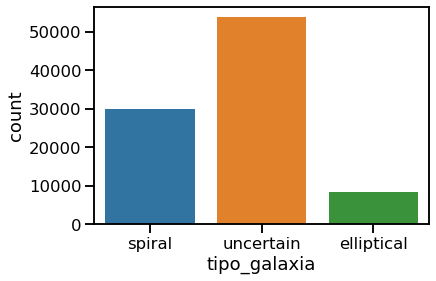

In [30]:
seaborn.countplot(x=data.tipo_galaxia)

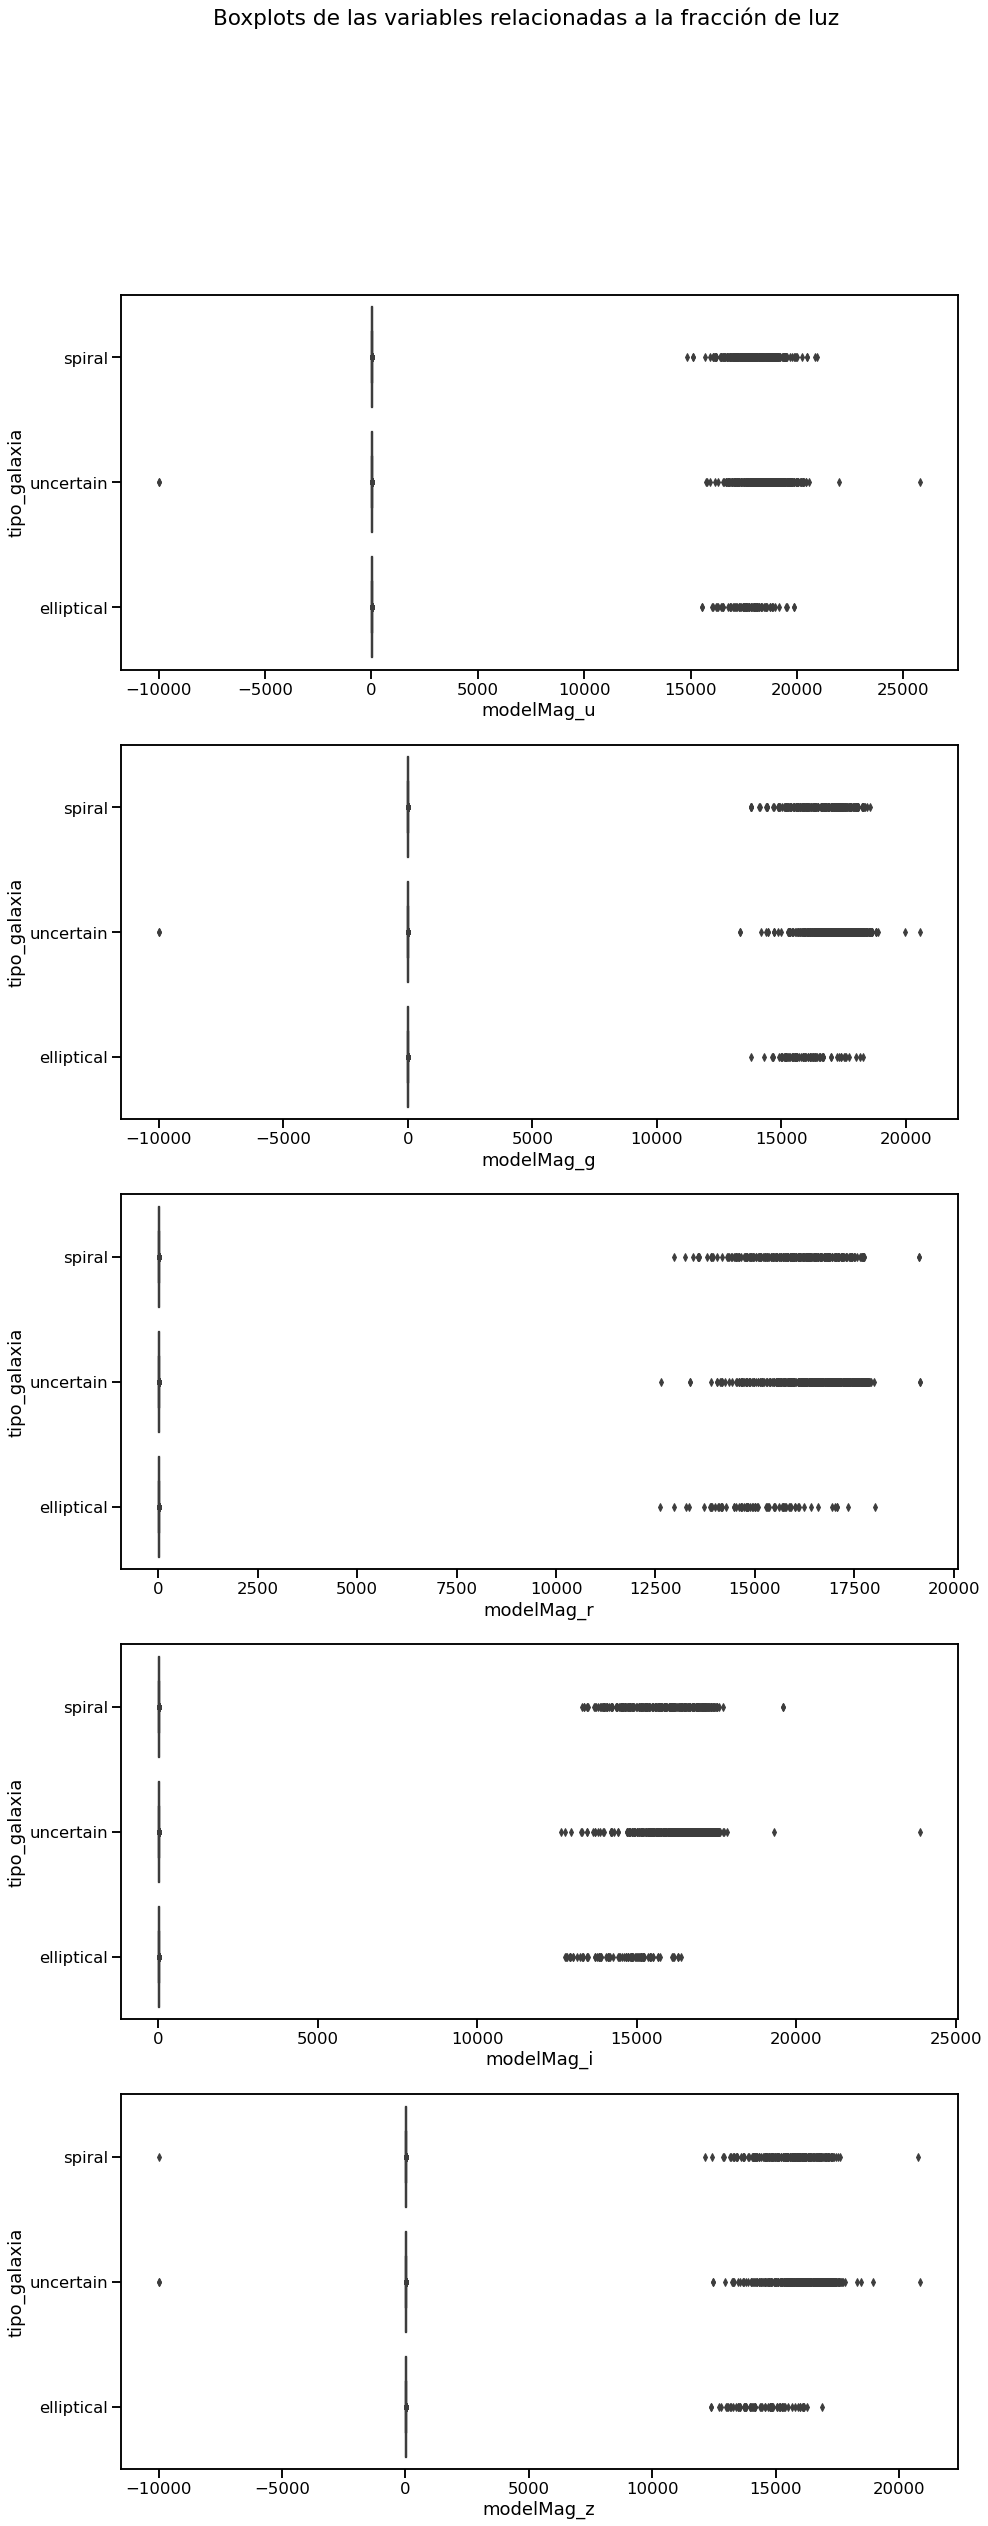

In [31]:
fig, ax = plt.subplots(nrows=5, figsize=(15,40))
seaborn.boxplot(x=data['modelMag_u'], y=data['tipo_galaxia'], ax=ax[0])
seaborn.boxplot(x=data['modelMag_g'], y=data['tipo_galaxia'], ax=ax[1])
seaborn.boxplot(x=data['modelMag_r'], y=data['tipo_galaxia'], ax=ax[2])
seaborn.boxplot(x=data['modelMag_i'], y=data['tipo_galaxia'], ax=ax[3])
seaborn.boxplot(x=data['modelMag_z'], y=data['tipo_galaxia'], ax=ax[4])
plt.suptitle("Boxplots de las variables relacionadas a la fracción de luz")
plt.show()

Se observa que las galaxias de tipo uncertain tienen mas outliers

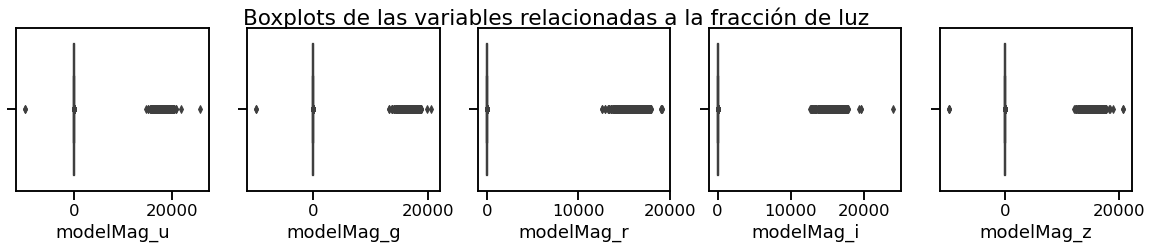

In [32]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3))
seaborn.boxplot(x=data['modelMag_u'], ax=ax[0])
seaborn.boxplot(x=data['modelMag_g'], ax=ax[1])
seaborn.boxplot(x=data['modelMag_r'], ax=ax[2])
seaborn.boxplot(x=data['modelMag_i'], ax=ax[3])
seaborn.boxplot(x=data['modelMag_z'], ax=ax[4])
plt.suptitle("Boxplots de las variables relacionadas a la fracción de luz")
plt.show()

Se observan outliers en las variables modelMag_u, modelMag_g y modelMag_z

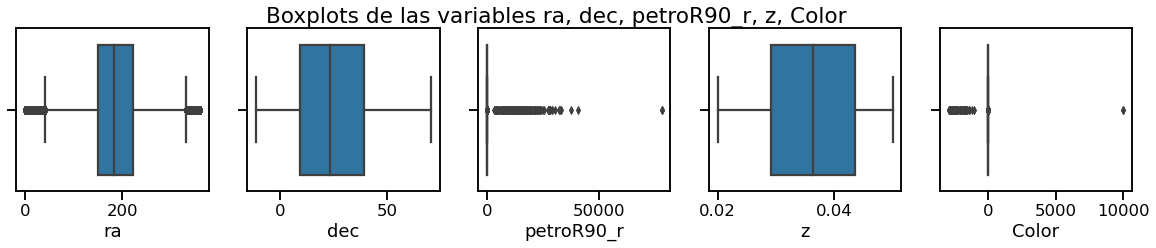

In [33]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3))
seaborn.boxplot(x=data['ra'], ax=ax[0])
seaborn.boxplot(x=data['dec'], ax=ax[1])
seaborn.boxplot(x=data['petroR90_r'], ax=ax[2])
seaborn.boxplot(x=data['z'], ax=ax[3])
seaborn.boxplot(x=data['Color'], ax=ax[4])
plt.suptitle("Boxplots de las variables ra, dec, petroR90_r, z, Color")
plt.show()

La variable ra ...

La variable dec ...

La variable petroR90_r ...

La variable z ...

La variable Color ...

In [34]:
count_ellpitical = data[data.tipo_galaxia == 'elliptical'].shape[0]
count_spiral = data[data.tipo_galaxia == 'spiral'].shape[0]
count_uncertain = data[data.tipo_galaxia == 'uncertain'].shape[0]
print(f'Cantidad de galaxias elliptical: {count_ellpitical}')
print(f'Cantidad de galaxias spiral: {count_spiral}')
print(f'Cantidad de galaxias uncertain: {count_uncertain}')

Cantidad de galaxias elliptical: 8256
Cantidad de galaxias spiral: 30003
Cantidad de galaxias uncertain: 53782


In [35]:
data.drop(['tipo_galaxia'], axis=1)

,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain
id,,,,,,,,,,,,,
"1,23765546806247",116.519097,39.886407,17.76235,16.72601,16.33972,16.06614,15.90478,8.393773,0.041521,-1.422625,0,1,0
"1,23765546806247",116.451900,41.421270,18.12179,16.26214,15.39272,14.97515,14.65105,9.674847,0.040211,-2.729061,0,0,1
"1,23765546806247",115.946713,41.918877,18.57293,17.42053,17.01788,16.75617,16.70899,11.277470,0.024386,-1.555044,0,0,1
"1,23765546806247",116.051943,42.287231,21.37438,19.77335,19.55791,20.35405,18.88184,1.539542,0.039137,-1.816479,0,0,1
"1,23765546806247",117.287392,43.434782,19.18845,17.99682,17.51119,17.26241,17.09056,12.471450,0.042591,-1.677259,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,23765546806247",245.038742,50.552353,19.65135,17.74399,16.86763,16.43538,16.09720,3.514471,0.048618,-2.783718,0,0,1
"1,23765546806247",219.313588,62.338577,18.77944,17.71890,17.35237,17.14414,17.04369,4.985637,0.036884,-1.427076,0,0,1
"1,23765546806247",239.043213,4.601942,18.93000,17.34099,16.79838,16.53403,16.52089,13.324690,0.034145,-2.131620,0,1,0


### Remplaze los valores faltantes/NaN/carentes de sentido físico con KNNImputer

Analizo variable ra, los valores no pueden ser menores a 0 o mayores a 360

In [36]:
print("Cantidad ra menores a 0: ",data[data.ra < 0].ra.count())
print("Cantidad ra mayores a 360: ",data[data.ra > 360].ra.count())

Cantidad ra menores a 0:  0
Cantidad ra mayores a 360:  0


Analizo variable dec, los valores no pueden ser menores a -90 o mayores a 90

In [37]:
print("Cantidad dec menores a -90: ",data[data.dec < -90].ra.count())
print("Cantidad dec mayores a 90: ",data[data.dec > 90].ra.count())

Cantidad dec menores a -90:  0
Cantidad dec mayores a 90:  0


In [38]:
data['petroR90_r'].describe()

count    92041.000000
mean        56.768694
std        921.480384
min          0.842248
25%          6.118412
50%          8.361988
75%         11.362450
max      78255.000000
Name: petroR90_r, dtype: float64

Estadísticos de la variable petroR90_r mayores a la media

In [39]:
data[data.petroR90_r > data.petroR90_r.mean()].petroR90_r.describe()

count      367.000000
mean     11888.493766
std       8520.216601
min         57.060260
25%       8904.500000
50%      11422.000000
75%      14719.500000
max      78255.000000
Name: petroR90_r, dtype: float64

In [40]:
data[data.petroR90_r > data.petroR90_r.mean()].petroR90_r.count() / data.petroR90_r.count() * 100

0.39873534620440887

Hay 369 valores petroR90_r mayores a la media, representa un 0.4 % del total de datos

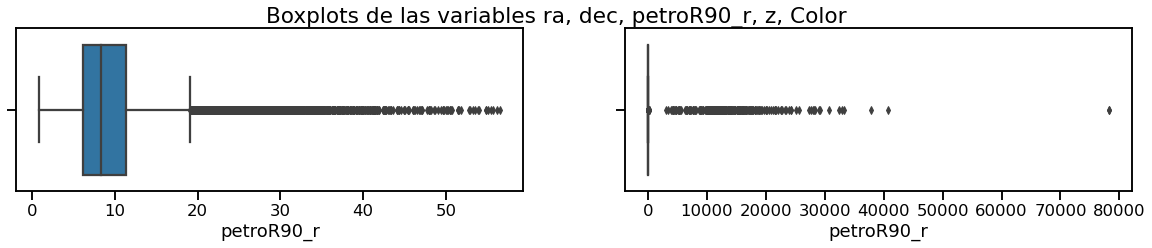

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(20,3))
seaborn.boxplot(x=data[data.petroR90_r < data.petroR90_r.mean()].petroR90_r, ax=ax[0])
seaborn.boxplot(x=data.petroR90_r, ax=ax[1])
plt.suptitle("Boxplots de las variables ra, dec, petroR90_r, z, Color")
plt.show()

In [42]:
data.notnull().all().to_frame()

,0
ra,True
dec,True
modelMag_u,True
modelMag_g,True
modelMag_r,True
modelMag_i,True
modelMag_z,True
petroR90_r,True
z,True
Color,True


No existen valores nulos

In [43]:
missing_values_count = df_main_inliers.isna().sum()
missing_values_count

NameError: name 'df_main_inliers' is not defined

<AxesSubplot:>

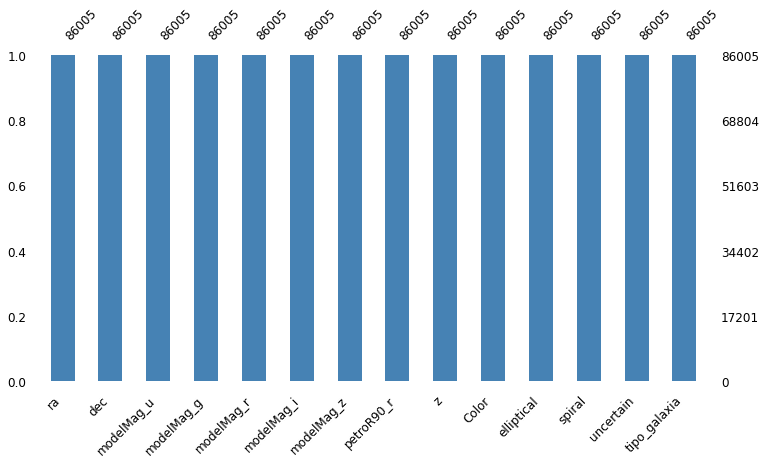

In [1039]:
msno.bar(df_main_inliers,figsize=(12, 6), fontsize=12, color='steelblue')

<AxesSubplot:>

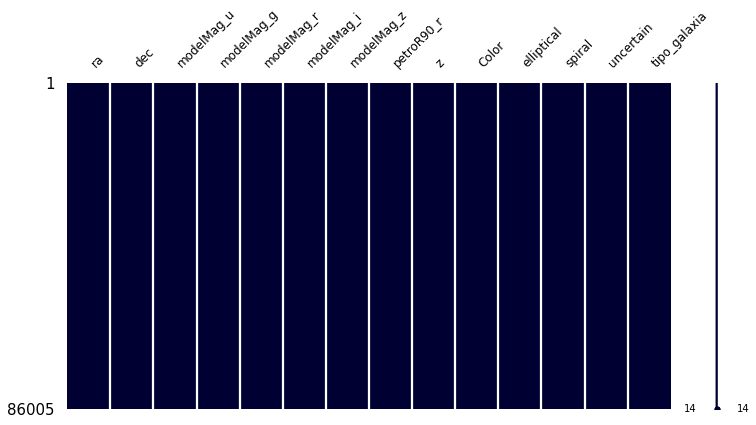

In [1040]:
msno.matrix(df_main_inliers,figsize=(12, 6), fontsize=12, color=[0,0,0.2])

No se observan variables nan

<span style="color: red">hay algo mal, qué valores imputar</span>

### Elimine los outliers de cada Feature, indique el porcentaje de valores que se están eliminando

Remoción de outliers de las variables relacionadas a la fracción de luz

In [44]:
iqr_factor = 2.5
df_main_inliers, df_main_outliers = remove_outlier(data, "modelMag_u", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "modelMag_g", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "modelMag_r", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "modelMag_i", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "modelMag_z", iqr_factor)
len(df_main_inliers) / len(data) * 100

95.3900978911572

Después de remover los outlier, la cantidad de datos obtenidos representa un 95%

In [45]:
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "ra", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "dec", iqr_factor)
#df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "petroR90_r", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "z", iqr_factor)
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "Color", iqr_factor)
len(df_main_inliers) / len(data) * 100

95.27819124086005

Después de remover los outliers, la cantidad de datos sigue representando un 95%

In [46]:
df_main_inliers, df_main_outliers = remove_outlier(df_main_inliers, "petroR90_r", iqr_factor)
len(df_main_inliers) / len(data) * 100

93.38881585380429

Luego de remover los outliers, el porcentaje en relación al dataframe original es elevado, un 93%. Se elimina un 7% del total de datos

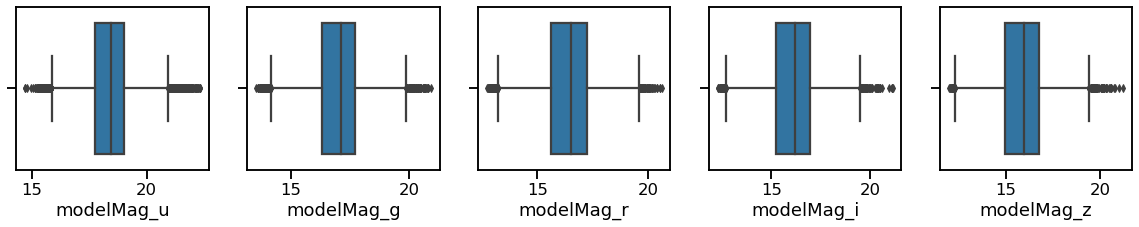

In [47]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3))
seaborn.boxplot(x=df_main_inliers['modelMag_u'], ax=ax[0])
seaborn.boxplot(x=df_main_inliers['modelMag_g'], ax=ax[1])
seaborn.boxplot(x=df_main_inliers['modelMag_r'], ax=ax[2])
seaborn.boxplot(x=df_main_inliers['modelMag_i'], ax=ax[3])
seaborn.boxplot(x=df_main_inliers['modelMag_z'], ax=ax[4])
plt.show()

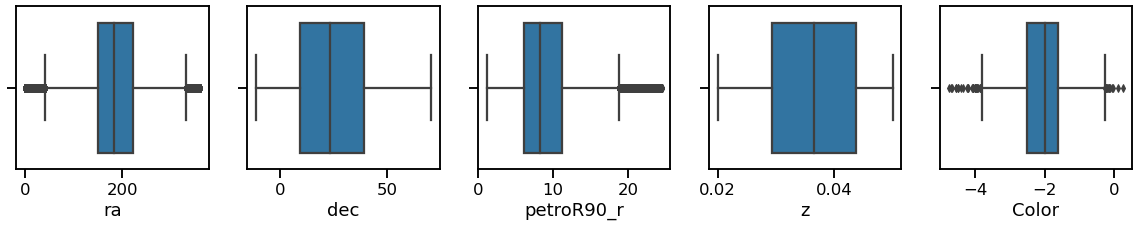

In [48]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3))
seaborn.boxplot(x=df_main_inliers['ra'], ax=ax[0])
seaborn.boxplot(x=df_main_inliers['dec'], ax=ax[1])
seaborn.boxplot(x=df_main_inliers['petroR90_r'], ax=ax[2])
seaborn.boxplot(x=df_main_inliers['z'], ax=ax[3])
seaborn.boxplot(x=df_main_inliers['Color'], ax=ax[4])
plt.show()

In [49]:
cols_with_zero = df_main_inliers[df_main_inliers == 0].count(axis=0)
cols_with_zero[cols_with_zero > 0]

elliptical    78488
spiral        58298
uncertain     35126
dtype: int64

Las varibales de categoría de tipo de galaxia cuentan con ceros. Es lógico.

In [50]:
col_num = df_main_inliers.select_dtypes(['int', 'float']).columns

Distribución de las variables numéricas

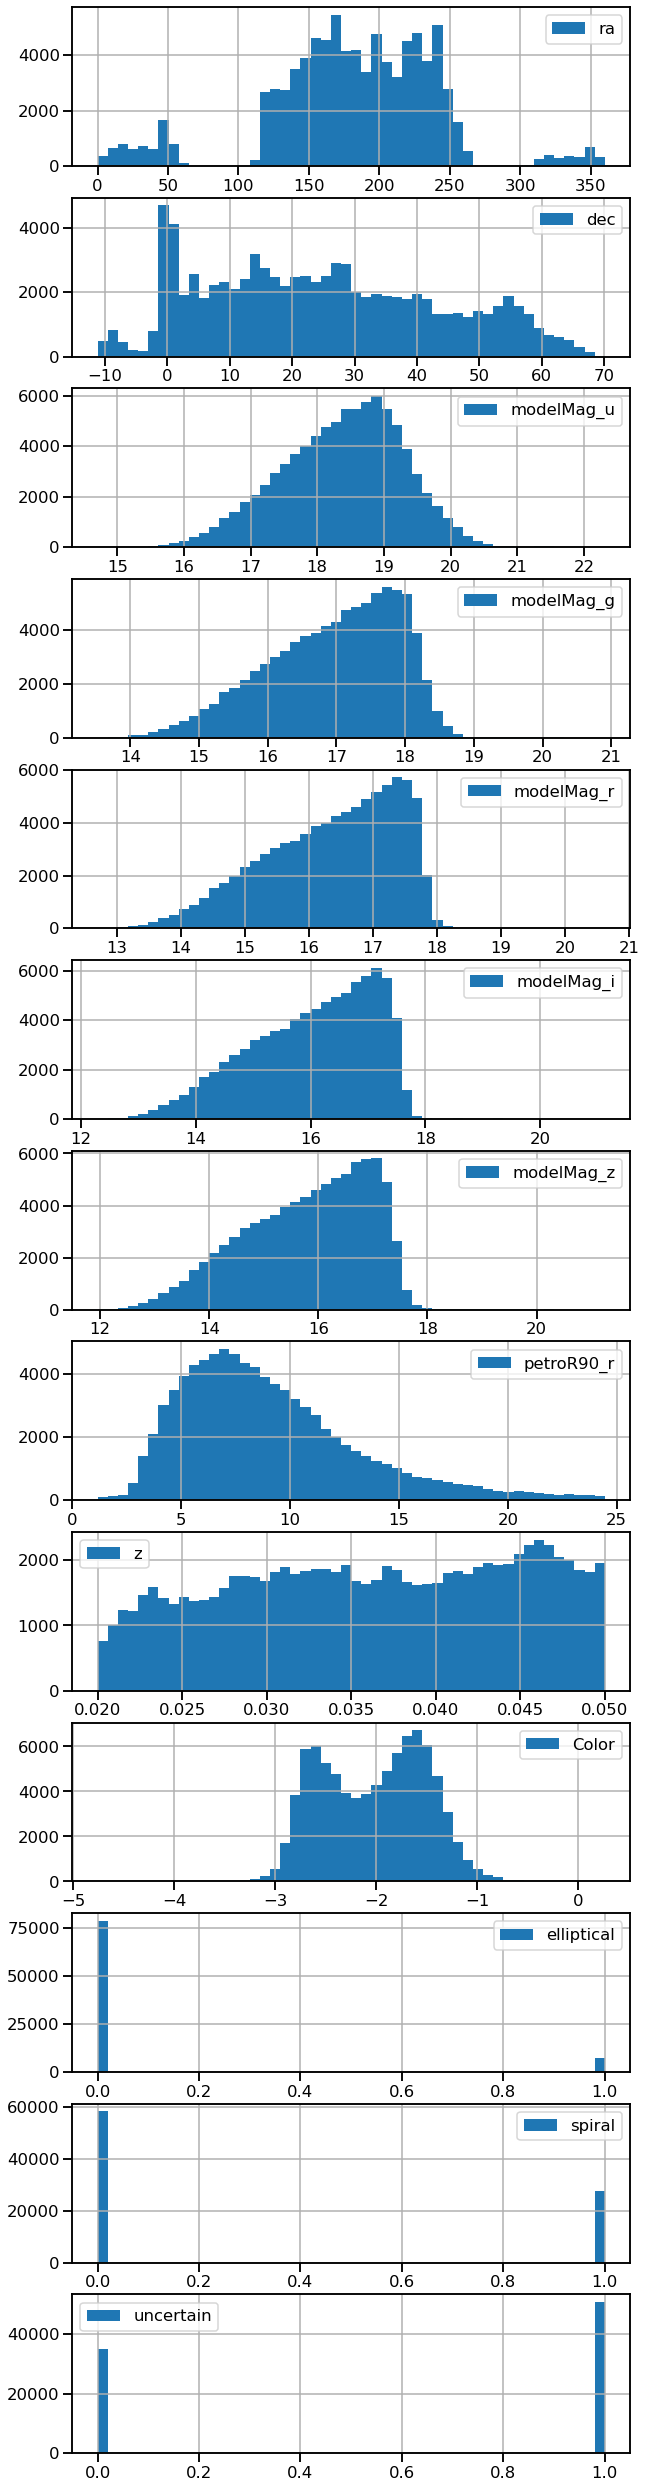

In [51]:
fig, axs = plt.subplots(len(col_num), figsize=(10, 45))
for n, col in enumerate(col_num):
    df_main_inliers[col].hist(ax=axs[n],bins=50, label=col)
    axs[n].legend()

A partir de los histogramas podemos observar que las varibles relacionadas a la fracción de luz tienden a una distribuciób normal, excepto las variables modelMag_z y modelMag_i.

La variable petroR900_r tiende a una distribución normal con una cola hacia la derecha.

La variable color tiende a una distribución chi cuadrado.

Se observa que la variable ra ...

### Genere un nuevo DataFramen (df1).

In [1351]:
df1 = df_main_inliers.copy()

### Cargar los valores de las imágenes correspondientes a las galaxias de df1.

Se toman las posciones angulares (ra, dec) de cada  galaxia y se descargan sus correspondientes imágenes en los filtros **g**, **r** y **z**. 

Todos los filtros para SDSS
**'Optical:SDSS**: ['SDSSg',
                  'SDSSi',
                  'SDSSr',
                  'SDSSu',
                  'SDSSz']

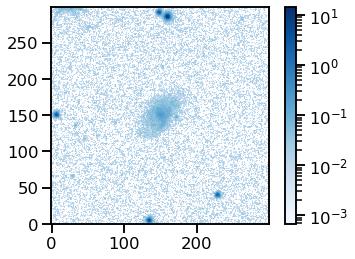

In [1050]:
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm

# Ejemplo de una sola imagen
coords_gx = SkyCoord(df1.ra.iloc[2], df1.dec.iloc[2], unit=(u.deg, u.deg))
img = SkyView.get_images(position=coords_gx, survey=['SDSSg', 'SDSSi', 'SDSSr', 'SDSSu', 'SDSSz'])

# Visualización de una de las galaxias.
img[0][0].data


plt.imshow(img[0][0].data, cmap='Blues', norm=LogNorm(), origin='lower')
plt.colorbar()

In [840]:
split = np.array_split(df1,10)

In [1338]:
df_temp = df1.index.drop_duplicates(keep='first')

In [1352]:
df1

,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,z,Color,elliptical,spiral,uncertain,tipo_galaxia
id,,,,,,,,,,,,,,
"1,23765546806247",116.519097,39.886407,17.76235,16.72601,16.33972,16.06614,15.90478,8.393773,0.041521,-1.422625,0,1,0,spiral
"1,23765546806247",116.451900,41.421270,18.12179,16.26214,15.39272,14.97515,14.65105,9.674847,0.040211,-2.729061,0,0,1,uncertain
"1,23765546806247",115.946713,41.918877,18.57293,17.42053,17.01788,16.75617,16.70899,11.277470,0.024386,-1.555044,0,0,1,uncertain
"1,23765546806247",116.051943,42.287231,21.37438,19.77335,19.55791,20.35405,18.88184,1.539542,0.039137,-1.816479,0,0,1,uncertain
"1,23765546806247",117.287392,43.434782,19.18845,17.99682,17.51119,17.26241,17.09056,12.471450,0.042591,-1.677259,0,0,1,uncertain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,23765546806247",245.038742,50.552353,19.65135,17.74399,16.86763,16.43538,16.09720,3.514471,0.048618,-2.783718,0,0,1,uncertain
"1,23765546806247",219.313588,62.338577,18.77944,17.71890,17.35237,17.14414,17.04369,4.985637,0.036884,-1.427076,0,0,1,uncertain
"1,23765546806247",239.043213,4.601942,18.93000,17.34099,16.79838,16.53403,16.52089,13.324690,0.034145,-2.131620,0,1,0,spiral


In [1350]:
images = {}
initial = 0
for index, row in df1.iterrows():
    if (initial < 25):
        coords_gx = SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg))
        img = SkyView.get_images(position=coords_gx, survey=['SDSSg', 'SDSSi', 'SDSSr', 'SDSSu', 'SDSSz'])
        print(index)
        images[index] = img
        initial += 1
        print(f">>> successfull downloading image {initial}")
print("finish")

1,23765546806247
>>> successfull downloading image 1
1,23765546806247
>>> successfull downloading image 2
1,23765546806247
>>> successfull downloading image 3
1,23765546806247
>>> successfull downloading image 4
1,23765546806247
>>> successfull downloading image 5
1,23765546806247
>>> successfull downloading image 6
1,23765546806247
>>> successfull downloading image 7
1,23765546806247
>>> successfull downloading image 8
1,23765546806247
>>> successfull downloading image 9
1,23765546806247
>>> successfull downloading image 10
1,23765546806247
>>> successfull downloading image 11
1,23765546806247
>>> successfull downloading image 12
1,23765546806247
>>> successfull downloading image 13
1,23765546806247
>>> successfull downloading image 14
1,23765546806247
>>> successfull downloading image 15
1,23765546806247
>>> successfull downloading image 16
1,23765546806247
>>> successfull downloading image 17
1,23765546806247
>>> successfull downloading image 18
1,23765546806247
>>> successfull down

KeyboardInterrupt: 

In [1054]:
images = []
initial = 0
total = len(df1)

for index, row in df_tmp[['ra','dec']].iterrows():
    if (initial < total):
        coords_gx = SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg))
        img = SkyView.get_images(position=coords_gx, survey=['SDSSg', 'SDSSi', 'SDSSr', 'SDSSu', 'SDSSz'])
        images.append(img)
        initial += 1
        print(f">>> successfull downloading image {initial}")
    else:
        print(f"Finish downloading from {initial} to {total} images")
        print("wait 5 seconds")
        time.sleep(5)
        total += 10

>>> successfull downloading image 1


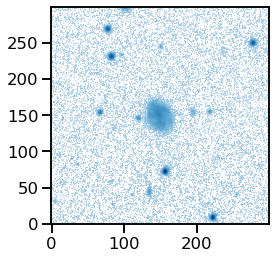

In [1081]:
# por cada filtro survey=['SDSSg', 'SDSSi', 'SDSSr', 'SDSSu', 'SDSSz'] obtiene un array de 300
plt.imshow(images[0][0][0].data, cmap='Blues', norm=LogNorm(), origin='lower')

In [1088]:
len(images[1][0][0].data)

300

In [1105]:
type(images[0][0][0])

astropy.io.fits.hdu.image.PrimaryHDU

In [1108]:
display(images[0][0][0].data[1])

array([ 0.01225281,  0.01225281,  0.03552246,  0.00892639, -0.01434326,
       -0.04095459, -0.02099609, -0.02099609, -0.00437927,  0.02886963,
       -0.0043869 , -0.02099609,  0.00558472, -0.03430176,  0.00891113,
        0.00891113,  0.0022583 , -0.00771332,  0.02883911, -0.00439453,
        0.02883911, -0.01435852, -0.01104736,  0.01554871,  0.01222229,
        0.01554871,  0.00556946,  0.04876709,  0.03881836,  0.01885986,
        0.04876709,  0.01220703,  0.01553345,  0.02218628,  0.01220703,
       -0.00440979, -0.00440979,  0.01885986,  0.00888062, -0.0010891 ,
       -0.03436279, -0.00774384,  0.01885986,  0.03546143,  0.03546143,
        0.01885986, -0.01438904, -0.00441742,  0.01551819, -0.03100586,
       -0.01773071,  0.01882935,  0.00886536,  0.03546143, -0.02767944,
        0.01551819,  0.04876709,  0.02215576,  0.02215576, -0.00775146,
        0.03875732, -0.0144043 , -0.05096436, -0.00443268, -0.0144043 ,
        0.00553131,  0.02215576, -0.02438354,  0.00220871,  0.04

Muestre:

    - Qué tamaños tienen las imágenes. 
    - Cuántas bandas/filtros tiene cada imagen.
    
Genere un dataframe (df2) en donde cada fila es una imagen y las columnas son los valores de cada px por filtro, por lo tanto, si las imagenes tienen un tamaño (Xpx, Ypx) y cunta con f filtros, entonces la cantidad de columnas de df2 son Xpx\*Ypx\*f. 

In [1324]:
df2 = pd.DataFrame({})

In [1228]:
survey = ['SDSSg', 'SDSSi', 'SDSSr', 'SDSSu', 'SDSSz']

In [1247]:
images_backup = images.copy()

In [1325]:
survey = ['SDSSg', 'SDSSi', 'SDSSr', 'SDSSu', 'SDSSz']
count_image = 0
# recorre cada imagen
for image in images_backup:
    # contador para identificar filtro
    count_filter = 0
    # fila_imagen
    row = {}
    # recorro cada filtro
    for filtro in image:
        x_values = filtro[0].data[0]
        y_values = filtro[0].data[1]
        # recorro arrays de x, y
        for i in range(len(filtro[0].data)):
            filter_name = survey[count_filter] # filtro actual
            current = i + 1 # valor actual
            col_x_name = "x_{current}_f_{filter_name}".format(current=current,filter_name=filter_name) # columna_x x_1_f_SDSSg
            col_y_name = "y_{current}_f_{filter_name}".format(current=current,filter_name=filter_name) # columna_y y_1_f_SDSSg
            x_value = x_values[i]
            y_value = y_values[i]
            row[col_x_name] = x_value
            row[col_y_name] = y_value
        count_filter += 1
    df2 = df2.append(row, ignore_index=True)
    count_image += 1
    print(f"finish image #{count_image}")
print("finish generate df2")

finish image #1
finish image #2
finish image #3
finish image #4
finish image #5
finish image #6
finish image #7
finish image #8
finish image #9
finish image #10
finish image #11
finish image #12
finish image #13
finish image #14
finish image #15
finish image #16
finish image #17
finish image #18
finish image #19
finish image #20
finish image #21
finish image #22
finish image #23
finish image #24
finish image #25
finish generate df2


In [1326]:
df2

,x_100_f_SDSSg,x_100_f_SDSSi,x_100_f_SDSSr,x_100_f_SDSSu,x_100_f_SDSSz,x_101_f_SDSSg,x_101_f_SDSSi,x_101_f_SDSSr,x_101_f_SDSSu,x_101_f_SDSSz,...,y_99_f_SDSSg,y_99_f_SDSSi,y_99_f_SDSSr,y_99_f_SDSSu,y_99_f_SDSSz,y_9_f_SDSSg,y_9_f_SDSSi,y_9_f_SDSSr,y_9_f_SDSSu,y_9_f_SDSSz
0,0.028748,-0.040283,0.063599,-0.015594,-0.110107,0.015472,-0.090210,0.008102,-0.104614,0.129883,...,0.008835,-0.104492,-0.027252,0.073486,0.027039,-0.004379,-0.125488,-0.017059,-0.096558,-0.212891
1,-0.022461,-0.015091,-0.013184,-0.021576,0.181396,0.013962,-0.040466,-0.022888,0.007065,-0.033020,...,-0.004257,0.016663,0.006241,-0.002480,-0.175781,-0.007965,-0.014664,0.040405,0.073975,-0.175293
2,0.000793,0.026428,-0.011566,0.011444,-0.168701,0.019653,-0.020111,0.002739,-0.023163,0.177734,...,0.008347,0.046326,-0.016327,-0.009338,-0.030151,-0.006668,-0.000062,0.002819,-0.016296,-0.122192
3,-0.000477,0.125244,0.097900,-0.026031,0.127441,0.007187,-0.001762,-0.008148,0.052368,-0.174561,...,0.003353,0.051697,-0.008163,0.002483,-0.035156,-0.008102,0.098877,-0.051819,0.045166,0.567383
4,-0.036255,-0.007240,0.042297,-0.045349,0.044128,0.016632,-0.086914,-0.010178,-0.017731,-0.326172,...,-0.017365,0.052551,0.013672,-0.059143,-0.279785,0.009125,-0.033691,0.004135,0.037598,-0.094116
5,0.001217,-0.084229,-0.078491,0.059753,0.027588,0.022461,0.016510,0.041504,-0.013382,0.282715,...,-0.016479,0.024261,0.051147,-0.005249,0.155273,0.045532,0.097412,0.022614,0.079346,-0.020874
6,0.040344,0.014191,-0.012787,-0.025116,-0.037842,-0.005684,0.096680,0.035828,-0.017181,-0.000663,...,0.036804,-0.036621,-0.012787,-0.025116,-0.298340,0.058716,0.033264,0.036194,0.022461,0.372070
7,-0.007469,-0.046021,0.000937,0.032532,0.295898,0.031372,-0.046021,-0.009354,0.096680,-0.399902,...,0.035278,0.082397,-0.004211,0.014236,0.132080,0.023590,-0.032654,-0.014511,0.078247,-0.072998
8,0.004456,-0.026642,0.033264,-0.050781,-0.186523,0.043823,-0.006432,-0.022217,0.110718,-0.186523,...,-0.015228,0.020538,-0.007065,0.083862,0.009445,0.020203,-0.032959,0.053650,0.038879,0.088501
9,0.004456,-0.026642,0.033264,-0.050781,-0.186523,0.043823,-0.006432,-0.022217,0.110718,-0.186523,...,-0.015228,0.020538,-0.007065,0.083862,0.009445,0.020203,-0.032959,0.053650,0.038879,0.088501


Tome una sola fila de df2 y muestre a partir de un gráfico la distribución de valores de los px en cada filtro en un rango de pxs.

In [1329]:
df2.loc[0]

x_100_f_SDSSg    0.028748
x_100_f_SDSSi   -0.040283
x_100_f_SDSSr    0.063599
x_100_f_SDSSu   -0.015594
x_100_f_SDSSz   -0.110107
                   ...   
y_9_f_SDSSg     -0.004379
y_9_f_SDSSi     -0.125488
y_9_f_SDSSr     -0.017059
y_9_f_SDSSu     -0.096558
y_9_f_SDSSz     -0.212891
Name: 0, Length: 3000, dtype: float64

<AxesSubplot:xlabel='0', ylabel='Count'>

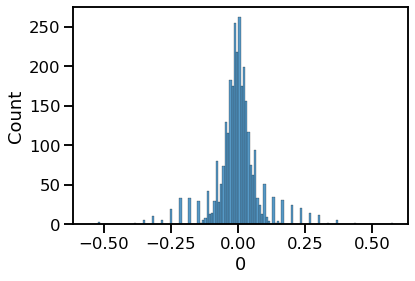

In [1330]:
seaborn.histplot(data=df2.loc[0])

<AxesSubplot:xlabel='0'>

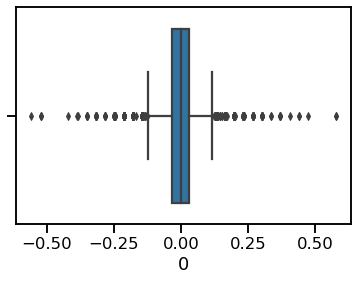

In [1331]:
seaborn.boxplot(x=df2.loc[0])

Por ultimo una df1 y df2 y guarde como un .csv

# Componentes Principales 

Ajuste el modelo de CPA  al df1 con n=3 el número de componentes principales. Grafique.